In [1]:
import sys
sys.path.insert(0, '/scratch_net/biwidl214/jonatank/code_home/restor_MAP/')

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
from datasets import brats_dataset_subj
import torch.nn as nn

import torch.optim as optim
from utils.utils import total_variation

In [14]:
data_path = "/scratch_net/biwidl214/jonatank/data/dataset_abnormal/new/brats17/"
img_size = 128
batch_size = 7

slices = [19163, 16109, 23161, 6096, 750, 3559, 1111]
#30, 19163, 23403, 17803, 16109, 23463, 2719, 23466, 1796, 21503, 5887, 6096, 23158, 25330,
#[25346, 25359, 25365, 25335, 25243, 25342, 25250, 25296, 25309, 25350, 25288, 25319, 25378, 25276, 25265, 25264, 25324, 25337, 25271, 25366, 25300, 25244, 25260, 25245, 25339, 25375, 25311, 25313, 25290, 25357,
##                      25343, 25347, 25322, 25256, 25328, 25340, 25331, 25374, 25345, 25285, 25323, 25316, 25349, 25252, 25351,
 #                     25364, 25317, 25330, 25239, 25240, 25314, 25332, 25280, 25344, 25301, 25286, 25363, 25302, 25274, 25315,
 #                     25255, 25368, 25321, 25292, 25373, 25241, 25293, 25238, 25270, 25253, 25305, 25320, 25371, 25272, 25353,
 #                     25247, 25333, 25304, 25254, 25278, 25279, 25299, 25277, 25294, 25369, 25297, 25251, 25361, 25283, 25303,
 #                     25336, 25248, 25356, 25258, 25263, 25257, 25275, 25259, 25307, 25282, 25318, 25327, 25370, 25354, 25325,
 #                     25358, 25376, 25262, 25269, 25291, 25266, 25237, 25329, 25362, 25312, 25242, 25341, 25355, 25360, 25268]

val_subj_dataset = brats_dataset_subj(data_path, 'train', img_size, slices, use_aug=False)
val_subj_loader = data.DataLoader(val_subj_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

Loading train set for subj


(-0.5, 127.5, 127.5, -0.5)

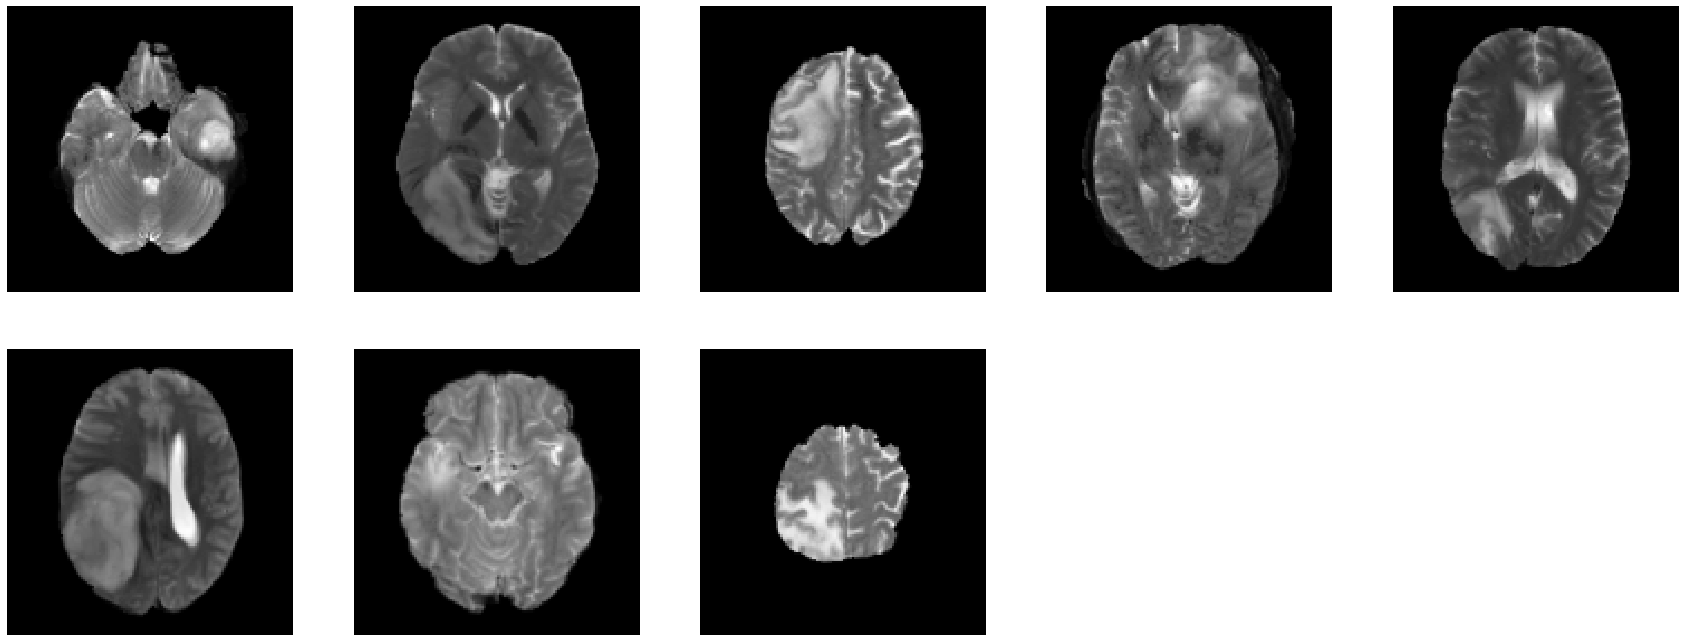

In [15]:
scan, seg, mask = next(iter(val_subj_loader))

plt.figure(figsize=(30,43.1))
plt.subplot(7, 5, 1)
plt.imshow(scan[0].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 5, 2)
plt.imshow(scan[1].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 5, 3)
plt.imshow(scan[2].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 5, 4)
plt.imshow(scan[3].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 5, 5)
plt.imshow(scan[4].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 5, 6)
plt.imshow(scan[5].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 5, 7)
plt.imshow(scan[6].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 5, 8)
plt.imshow(scan[7].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')

In [16]:


def run_map_TV(input_img, dec_mu, vae_model, riter, device, weight = 1, step_size=0.003):
    # Init params
    input_img = nn.Parameter(input_img, requires_grad=False)
    dec_mu = nn.Parameter(dec_mu.float(), requires_grad=False)
    img_ano = nn.Parameter(input_img.clone(),requires_grad=True)

    input_img = input_img.to(device)
    dec_mu = dec_mu.to(device)
    img_ano = img_ano.to(device)

    # Init Optimizer
    MAP_optimizer = optim.Adam([img_ano], lr=step_size)

    # Iterate until convergence
    for i in range(riter):
        __, z_mean, z_cov, __ = vae_model(img_ano.unsqueeze(1).double())

        # Define G function
        l2_loss = (dec_mu.view(-1, dec_mu.numel()) - img_ano.view(-1, img_ano.numel())).pow(2)
        kl_loss = -0.5 * torch.sum(1 + z_cov - z_mean.pow(2) - z_cov.exp())

        gfunc = torch.sum(l2_loss) + kl_loss + weight * total_variation(img_ano-input_img)

        gfunc.backward() # Backpropogate

        torch.clamp(img_ano, -100, 100) # Limit gradients to -100 and 100

        MAP_optimizer.step() # X' = X + lr_rate*grad(gfunc(X))
        MAP_optimizer.zero_grad()

    return img_ano

In [17]:
vae_path = '/scratch_net/biwidl214/jonatank/logs/vae/'
path = vae_path + "camcan_400_Aug_6_100" + '.pth'
vae_model = torch.load(path, map_location=torch.device("cpu"))
vae_model.eval()

scan, seg, mask = next(iter(val_subj_loader))
decoded_mu = torch.zeros(scan.size())
for s in range(25):
    recon_batch, z_mean, z_cov, res = vae_model(scan.double())
    decoded_mu += np.array([1 * recon_batch[i].detach().cpu().numpy() for i in range(scan.size()[0])])

decoded_mu = decoded_mu / 25

# Remove channel
scan = scan.squeeze(1)
seg = seg.squeeze(1)
mask = mask.squeeze(1)

img_ano = run_map_TV(scan, decoded_mu, vae_model, 250, "cpu", 2, 0.003)


seg_map = torch.abs(img_ano-scan.squeeze(1))

seg_map = seg_map*mask

thres = 0.00656

seg_b = seg_map.clone()
seg_b[seg_b >= thres] = 1
seg_b[seg_b < thres] = 0

/scratch_net/biwidl214/jonatank/anaconda3/envs/JKMT/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'networks.vae_bilinear_conv.ResBlock_Down' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/scratch_net/biwidl214/jonatank/anaconda3/envs/JKMT/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'networks.vae_bilinear_conv.ResBlock_Up' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


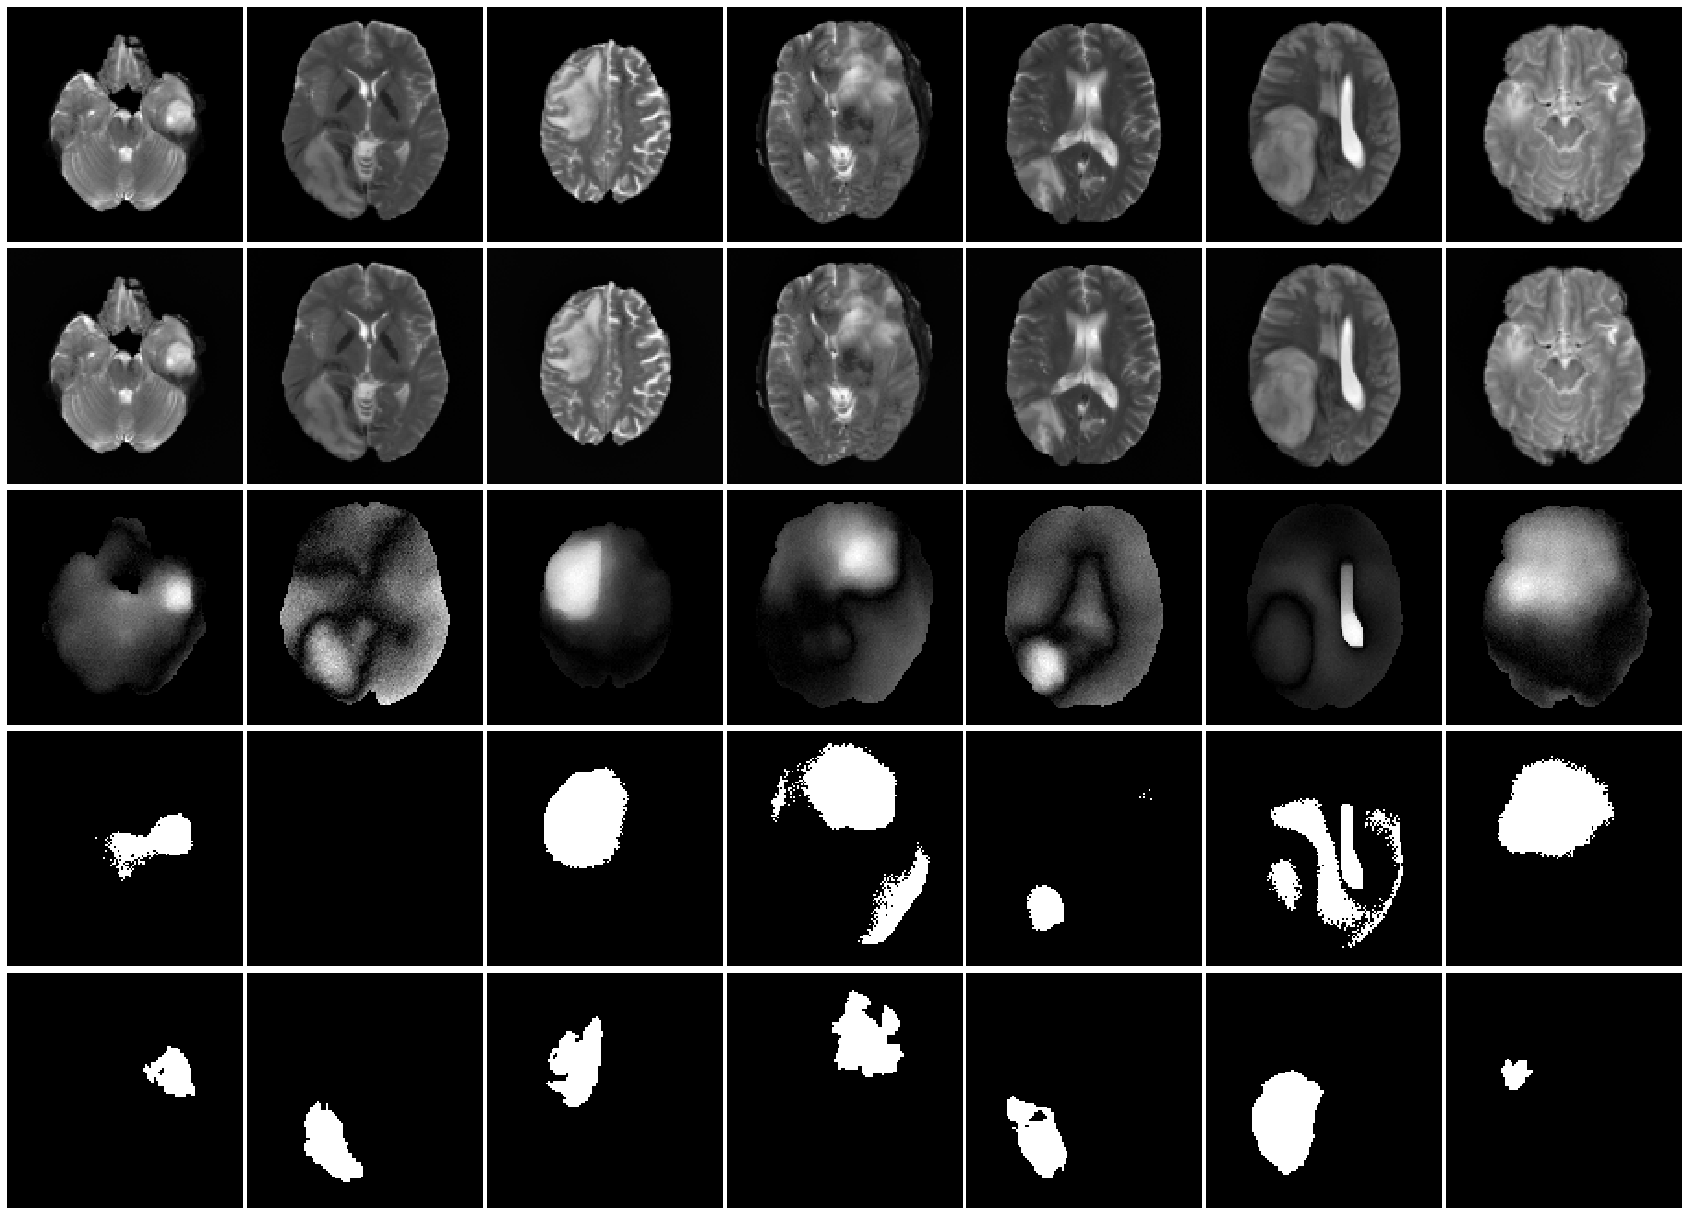

In [24]:
plt.figure(figsize=(30,31))
plt.subplot(7, 7, 1)
plt.imshow(scan[0].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 2)
plt.imshow(scan[1].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 3)
plt.imshow(scan[2].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 4)
plt.imshow(scan[3].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 5)
plt.imshow(scan[4].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 6)
plt.imshow(scan[5].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 7)
plt.imshow(scan[6].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
### ROW 1
plt.subplot(7, 7, 8)
plt.imshow(img_ano[0].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 9)
plt.imshow(img_ano[1].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 10)
plt.imshow(img_ano[2].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 11)
plt.imshow(img_ano[3].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 12)
plt.imshow(img_ano[4].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 13)
plt.imshow(img_ano[5].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 14)
plt.imshow(img_ano[6].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
"""
### ROW 2
plt.subplot(7, 5, 11)
plt.imshow(elbo_grad[0].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 5, 12)
plt.imshow(elbo_grad[1].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 5, 13)
plt.imshow(elbo_grad[2].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 5, 14)
plt.imshow(elbo_grad[3].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 5, 15)
plt.imshow(elbo_grad[4].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
### ROW 3
plt.subplot(7, 5, 16)
plt.imshow(out[0].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 5, 17)
plt.imshow(out[1].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 5, 18)
plt.imshow(out[2].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 5, 19)
plt.imshow(out[3].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 5, 20)
plt.imshow(out[4].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
"""
### ROW 4
plt.subplot(7, 7, 15)
plt.imshow(seg_map[0].detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 16)
plt.imshow(seg_map[1].detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 17)
plt.imshow(seg_map[2].detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 18)
plt.imshow(seg_map[3].detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 19)
plt.imshow(seg_map[4].detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 20)
plt.imshow(seg_map[5].detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 21)
plt.imshow(seg_map[6].detach().numpy() , cmap='gray')
plt.axis('off')
# ROW 6
plt.subplot(7, 7, 22)
plt.imshow(seg_b[0].squeeze(0).detach().numpy(), cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 23)
plt.imshow(seg_b[1].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 24)
plt.imshow(seg_b[2].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 25)
plt.imshow(seg_b[3].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 26)
plt.imshow(seg_b[4].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 27)
plt.imshow(seg_b[5].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 28)
plt.imshow(seg_b[6].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
# ROW 6
plt.subplot(7, 7, 29)
plt.imshow(seg[0].squeeze(0).detach().numpy(), cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 30)
plt.imshow(seg[1].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 31)
plt.imshow(seg[2].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 32)
plt.imshow(seg[3].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 33)
plt.imshow(seg[4].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 34)
plt.imshow(seg[5].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplot(7, 7, 35)
plt.imshow(seg[6].squeeze(0).detach().numpy() , cmap='gray')
plt.axis('off')
plt.subplots_adjust(wspace=0.02, hspace=0.02)
